In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

## Prepare model

In [2]:
coarse_factors = [32]
Directory = f"data"

variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

len_samples = nz*len(variables)
len_in = nz*(len(variables)-1)
len_out = nz

In [3]:
model_number = 10

train_times = pd.read_csv(Directory+f'/test_train_times/times_train_{model_number}.csv').drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
test_times = pd.read_csv(Directory+f'/test_train_times/times_test_{model_number}.csv').drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
print(train_times)
print(test_times)

[20 43 47 17 32 36 46  1 58 40  9 48 23 50  8 38  4 30 13 27 19 25  5 55
 45  3 49 60 56 34 42 31 54 16 21 26 61 15 11 59 14 10 62 33  2 39 29 51
 52]
[24 18  7 22 53 44 41 12 35 37  6 57 28]


In [4]:
input_train, output_train, input_test, output_test = utils.make_train_test_ds(coarse_factors, len_in, train_times, test_times, Directory)

In [5]:
class DNN(nn.Module):
    def __init__(self, batch_size, input_size, output_size, drop_prob1=0.2, drop_prob2=0.3, drop_prob3=0.4, hidden_size1=1024, hidden_size2=512, hidden_size3=256):
        super(DNN, self).__init__()
        self.regression = nn.Sequential(nn.Linear(input_size, hidden_size1),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob1),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob2),
                                        nn.Linear(hidden_size2, hidden_size3),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob3),
                                        nn.Linear(hidden_size3, output_size)
                                        )
        self.drop_prob1 = drop_prob1
        self.drop_prob2 = drop_prob2
        self.drop_prob3 = drop_prob3
        self.batch_size = batch_size
        self.input_shape = input_size
        self.output_shape = output_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3

    
    def forward(self, x):
        return self.regression(x)

## Load model

In [6]:
learning_rate = 0.001
batch_size = 16
nb_epochs = 20
train_losses=[]
test_losses=[]

model_load = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
model_load.load_state_dict(torch.load(f'explo/models/simple_dnn{model_number}'))
model_load.eval()

DNN(
  (regression): Sequential(
    (0): Linear(in_features=2256, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=256, out_features=376, bias=True)
  )
)

In [7]:
model_load.parameters()

<generator object Module.parameters at 0x11c9a09e0>

In [8]:
for param_tensor in model_load.state_dict():
    print(param_tensor, "\t", model_load.state_dict()[param_tensor].size())

regression.0.weight 	 torch.Size([1024, 2256])
regression.0.bias 	 torch.Size([1024])
regression.3.weight 	 torch.Size([512, 1024])
regression.3.bias 	 torch.Size([512])
regression.6.weight 	 torch.Size([256, 512])
regression.6.bias 	 torch.Size([256])
regression.9.weight 	 torch.Size([376, 256])
regression.9.bias 	 torch.Size([376])


In [9]:
model_load.state_dict()['regression.0.weight']

tensor([[ 0.0204,  0.0128, -0.0116,  ..., -0.0010,  0.0046,  0.0102],
        [ 0.0021,  0.0004, -0.0052,  ..., -0.0112,  0.0002, -0.0034],
        [-0.0080,  0.0008, -0.0085,  ...,  0.0193, -0.0032, -0.0029],
        ...,
        [ 0.0107, -0.0132,  0.0137,  ..., -0.0146, -0.0082,  0.0156],
        [-0.0005, -0.0053,  0.0173,  ...,  0.0052, -0.0093, -0.0081],
        [ 0.0068, -0.0151,  0.0163,  ...,  0.0112, -0.0093, -0.0083]])

In [59]:
X = input_test[100].numpy()
T = output_test[100].numpy()

W = []
B=[]
for param_tensor in model_load.state_dict():
    if param_tensor.__contains__("weight"):
        W.append(model_load.state_dict()[param_tensor].cpu().detach().numpy())
    if param_tensor.__contains__("bias"):
        B.append(model_load.state_dict()[param_tensor].cpu().detach().numpy())
L = len(W)

In [60]:
A = [X]+[None]*L
print(A[0].shape)
for l in range(L):
    A[l+1] = np.maximum(0,A[l].dot(W[l].T)+B[l])
    print(A[l+1].shape)


(2256,)
(1024,)
(512,)
(256,)
(376,)


In [61]:

R = [None]*L + [A[L]*T]

In [62]:
def rho(w,l):  return w #+ [None,0.1,0.0,0.0][l] * np.maximum(0,w)
def incr(z,l): return z #+ [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9


In [63]:
for l in range(1,L)[::-1]:
    w = rho(W[l],l)
    b = rho(B[l],l)
    
    z = incr(A[l].dot(w.T)+b,l)   # step 1
    #z= z.reshape(z.shape[0])
    s = R[l+1] / z                # step 2
    c = s.dot(w)               # step 3
    R[l] = A[l]*c                # step 4


In [64]:
w  = W[0]
wp = np.maximum(0,w)
wm = np.minimum(0,w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w.T)-lb.dot(wp.T)-hb.dot(wm.T)+1e-9    # step 1
s = R[1]/z                                          # step 2
c,cp,cm  = s.dot(w),s.dot(wp),s.dot(wm)             # step 3
R[0] = A[0]*c-lb*cp-hb*cm                           # step 4


In [65]:
R[0].shape

(2256,)

In [66]:
plot_ds = R[0].reshape(376,6)
plot_ds.shape
print(plot_ds.min(), plot_ds.max())

-1.1549822e-05 1.1079575e-05


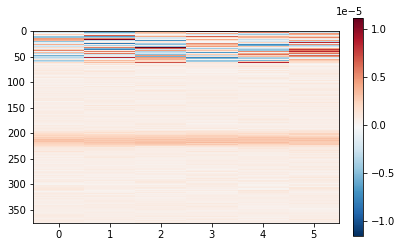

In [67]:
im = plt.imshow(plot_ds , cmap = 'RdBu_r' , interpolation = 'nearest', aspect=0.01)
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
plt.show()